In [149]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
import operator
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv()

True

In [150]:
# model

geneator = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0.7)

evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0.0)

optimizer = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0.4)

In [151]:
# output schema for evaluation

class EvaluationSchema(BaseModel):

      evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
      feedback: str = Field(..., description="feedback for the tweet.")
      score : int = Field(..., ge = 0, le = 10, description = "Total scores of tweet from 0 to 10, to tell how likely it will get popular and people will like")

In [152]:
# updated model

evaluator = evaluator_llm.with_structured_output(EvaluationSchema)

In [153]:
# state

class PostStatus(TypedDict):

      topic : str
      tweet : str
      evaluation : Literal["needs_improvement", "approved"]
      feedback : str
      score : Annotated[list[int], operator.add]
      epochs : int
      max_epochs : int

      tweet_history : Annotated[list[str], operator.add]
      feedback_history : Annotated[list[str], operator.add]

In [154]:
def generator_function(state : PostStatus) -> PostStatus:
      
      messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a tweet on the topic: "{state['topic']}".
""")
    ]
      res = geneator.invoke(messages).content
      iteration = 1

      return {"tweet" : res, "epochs" : iteration, "tweet_history" : [res]}

In [155]:
# messages = [
#         SystemMessage(content="You are a funny and clever Twitter/X influencer."),
#         HumanMessage(content=f"""
# Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
# 
# Rules:
# - Do NOT use question-answer format.
# - Max 280 characters.
# - Use observational humor, irony, sarcasm, or cultural references.
# - Think in meme logic, punchlines, or relatable takes.
# - Use simple, day to day english
# """)

In [156]:
def evaluator_function(state : PostStatus) -> PostStatus:
      
      messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses
- score: scores of the tweet from 0 to 10, to tell how likely it will get popular and people will like it
""")
]
      
      res = evaluator.invoke(messages)

      return {"evaluation" : res.evaluation, "feedback" : res.feedback, "score" : [res.score], "feedback_history" : [res.feedback]}

In [157]:
def optimizer_function(state : PostStatus) -> PostStatus:

      messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
      
      res = optimizer.invoke(messages)
      iteration = state['epochs'] + 1

      return {'tweet' : res, "epochs" : iteration, "tweet_history" : [res]}

In [158]:
def check_condition(state : PostStatus) -> Literal[""]:

      if state['evaluation'] == "approved" or state['epochs'] >= state['max_epochs']:
            return "approved"
      else:
            return "needs_improvement"

In [159]:
# create graph
graph = StateGraph(PostStatus)

# add nodes
graph.add_node("generator_function", generator_function)
graph.add_node("evaluator_function", evaluator_function)
graph.add_node("optimizer_function", optimizer_function)

# add edges
graph.add_edge(START, "generator_function")
graph.add_edge("generator_function", "evaluator_function")

graph.add_conditional_edges("evaluator_function", check_condition, {"approved" : END, "needs_improvement" : "optimizer_function"})

graph.add_edge("optimizer_function", "evaluator_function")

# compile
workflow = graph.compile()

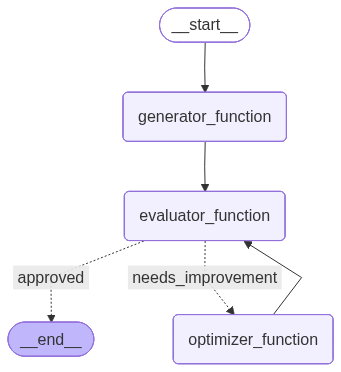

In [160]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
initail_state = {"topic" : "Which one is better ChatGPT5.2, Grock, Enthropic Claud Sonnet 4.5, Gemeni 3 and Kimi K2", "max_epochs" : 5}

final_state = workflow.invoke(initail_state)

In [ ]:
final_state

{'topic': 'Which one is better ChatGPT5.2, Grock, Enthropic Claud Sonnet 4.5, Gemeni 3 and Kimi K2',
 'tweet': 'ChatGPT5.2, Grock, Enthropic Claud Sonnet 4.5, Gemini 3, Kimi K2...\n\nHonestly, trying to pick the "best" one feels like I\'m doing a bracketology for future robot overlords.\n\nCan one of them just tell me what I should have for lunch? My human brain is clearly malfunctioning. 🤖🍔 #AI #TechHumor #BrainBuffering',
 'evaluation': 'approved',
 'feedback': 'The tweet is a solid example of relatable tech humor. It effectively uses current AI models to create a relatable scenario (choosing lunch) that highlights the overwhelming nature of choice in the rapidly evolving AI landscape. The use of emojis is appropriate and enhances the humor. The hashtags are relevant and well-chosen for discoverability. It is concise and well-formatted.',
 'score': [9],
 'epochs': 1,
 'max_epochs': 5,
 'tweet_history': ['ChatGPT5.2, Grock, Enthropic Claud Sonnet 4.5, Gemini 3, Kimi K2...\n\nHonestly,